# Part II. Graded.

**Due date december 1st**
You can also send your answers to the optional questions 

1. Based on the minimal code example with validation and $L_2$ prenality, implement your own version of a factorization machine. As we do want to use fields this is the same than a rank k asumption on the matrix of the second order terms which can be expressed as $<v_i, v_j>$ with $v_i \in \mathbb{R}^k$ .  Remind that 
$$
\frac{\partial}{\partial \theta} \hat{y}(\mathbf{x})= \begin{cases}1, & \text { if } \theta \text { is } \mbox{the bias term } \omega_0 \\ x_{i}, & \text { if } \theta \text { is } w_{i} \mbox{ (first order term)} \\ x_{i} \sum_{j=1}^{n} v_{j, f} x_{j}-v_{i, f} x_{i}^{2}, & \text { if } \theta \text { is the } i,f \mbox { second order term } <v_i,v_f>   \end{cases}
$$

One possibility to code it is to isolate the second order term within a second vector of parameters while performing the ```get_x``` and change the way the gradient is computed in the ```update_w``` function. Details about factorization machines are in the [original paper](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from csv import DictReader
from math import exp, log, sqrt
from datetime import datetime
import sklearn.metrics as m
import pandas as pd
import seaborn as sns

from numba import jit

In [2]:
D = 2 ** 20   # max number of weights to use (hash size)
alpha = .1    # learning rate for sgd optimization

y = np.genfromtxt('../data/y_train.csv', delimiter=',', skip_header=1)
y_mean = y[:,0].mean()
Hy =  -y_mean * log( y_mean) - (1-y_mean) *log(1-y_mean)

In [3]:
def get_x(csv_row, D):
    x = []
    x_squared = []
    for key, value in csv_row.items():
        index = int(value + key[4:], 16) % D 
        x.append(index)
    
    L = len(x)
    for i in range(L):
        index = (x[i] ** 2) % D 
        x_squared.append(index)
    return x, x_squared

def get_data(X_path, y_path):
    all_x = []
    all_x_squared = []
    all_y = []

    for t, (row, y) in enumerate(zip(DictReader(open(X_path)), DictReader(open(y_path)))):
        x, x_squared = get_x(row, D)
        all_x.append(x)
        all_x_squared.append(x_squared)
        all_y.append(float(y['click']))
        
    return np.array(all_x), np.array(all_x_squared), np.array(all_y)

 
try: 
    data_train = np.load('../data/data_train.npz')
    data_valid = np.load('../data/data_valid.npz')
    data_test = np.load('../data/data_test.npz')
    
    X_train, X_train_square, y_train = data_train['X_train'], data_train['X_train_square'], data_train['y_train']
    X_valid, X_valid_square, y_valid = data_valid['X_valid'], data_valid['X_valid_square'], data_valid['y_valid']
    X_test, X_test_square, y_test = data_test['X_test'], data_test['X_test_square'], data_test['y_test']

# Very very long 
except:
    X_train, X_train_square, y_train = get_data('../data/X_train.csv', '../data/y_train.csv')
    X_valid, X_valid_square, y_valid = get_data('../data/X_valid.csv', '../data/y_valid.csv') 
    X_test, X_test_square, y_test = get_data('../data/X_test.csv', '../data/y_test.csv') 

    np.savez('../data/data_train.npz', X_train=X_train, X_train_square=X_train_square, y_train=y_train)
    np.savez('../data/data_valid.npz', X_valid=X_valid, X_valid_square=X_valid_square, y_valid=y_valid)
    np.savez('../data/data_test.npz', X_test=X_test, X_test_square=X_test_square, y_test=y_test)

In [4]:
@jit(nopython=True)
def logloss(p, y):
    p = max(min(p, 1. - 10e-12), 10e-12)
    return -log(p) if y == 1. else -log(1. - p)

@jit(nopython=True)
def compute_validation_loss(w, V, X_valid, X_valid_square, y_valid):
    val_loss = 0 
    for i in range(len(X_valid)):
        x, x_squared, y = X_valid[i], X_valid_square[i], y_valid[i]
        p = get_p(x, x_squared, w, V)
        val_loss += logloss(p, y)
    return val_loss/i

@jit(nopython=True)
def get_p(x, x_squared, w, v):
    k = v.shape[1]
    wTx = 0.
    for i in x:  # do wTx
        wTx += w[i] * 1.  # w[i] * x[i], but if i in x we got x[i] = 1.
    
    sum_vTx_f = 0
    sum_vTx_f_squared = 0
    sum_of_square_vTx_f = 0
  
    for f in range(k) : 
        for i in x:
            sum_vTx_f += v[i][f]
        sum_vTx_f_squared += sum_vTx_f**2
        
        for j in x_squared : 
            sum_of_square_vTx_f += v[j][f]**2
    
    y_hat = wTx + 0.5 * (sum_vTx_f_squared-sum_of_square_vTx_f)
  
    return 1. / (1. + exp(-max(min(y_hat, 20.), -20.)))  # bounded sigmoid

@jit(nopython=True)
def update_wL2(w, v, n, x, x_squared, p, y, lbd=5e-4, alpha=.01):
    k = v.shape[1]
    error = p - y
    
    for i in x:
        w[i] -= (error + lbd * 2 * w[i]) * alpha / (sqrt(n[i]) + 1.) 
        n[i] += 1.
    
    sum_vTx_all_f = []
    for f in range(k) :
        sum_vTx_f = 0
        for i in x:
            sum_vTx_f += v[i][f] 
        sum_vTx_all_f.append(sum_vTx_f)
      
    for j in x_squared : 
        for f in range(k):
            v[j][f] -= (error*(sum_vTx_all_f[f] - v[j][f]) 
                        + lbd * 2 * v[j][f]) * alpha / (sqrt(n[j]) + 1.) 
        n[j] += 1.
    return w, v, n

@jit(nopython=True)
def predict(w, V, X_valid=X_valid, X_valid_square=X_valid_square):
    y_pred = np.zeros(len(X_valid))
    
    for i in range(len(X_valid)):
        x, x_squared = X_valid[i], X_valid_square[i]
        predict_proba = get_p(x, x_squared, w, V)
        y_pred[i] = 0 if predict_proba < 0.5 else 1

    return y_pred

In [5]:
@jit(nopython=True)
def train(X_train=X_train, X_train_square=X_train_square, y_train=y_train,
          X_valid=X_valid, X_valid_square=X_valid_square, y_valid=y_valid,
          k=5, D=2**24, n_epochs=5, alpha=.01):
    w = np.zeros(D)
    n = np.zeros(D)
    V = np.random.normal(0, 0.2, size=(D, k))
    inter_verb = 1000

    training_losses = np.zeros(n_epochs*len(X_train) // inter_verb)
    validation_losses = np.zeros(n_epochs*len(X_train) // inter_verb)    
    loss = 0.
    n_updates = 0
    n_save = 0
    for e in range(n_epochs):
        training_loss = 0
        for i in range(len(X_train)):
            x, x_squared, y = X_train[i], X_train_square[i], y_train[i]
            p = get_p(x, x_squared, w, V)
            training_loss += logloss(p, y)
            if n_updates % inter_verb == 0 and n_updates>1:
                training_losses[n_save] = training_loss/i
                validation_losses[n_save] = compute_validation_loss(w, V, X_valid, X_valid_square, y_valid)
                n_save += 1
            w, V, n = update_wL2(w, V, n, x, x_squared, p, y) 
            n_updates += 1
    
    return w, V, training_losses, validation_losses

In [6]:
def print_losses(training_losses, validation_losses):
    x = [10000*i for i in range(len(training_losses))]
    plt.plot(x, training_losses, label='Train')
    plt.plot(x, validation_losses, label='Validation')
    plt.xlabel('Number of updates')
    plt.ylabel('Log Loss')
    plt.legend( ('Train', 'Validation') )
    plt.show() 

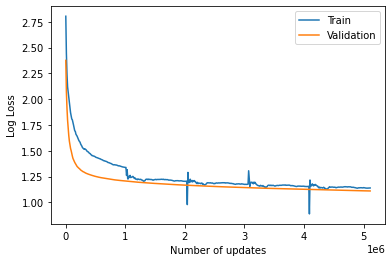

In [7]:
w, V, training_losses, validation_losses = train()
print_losses(training_losses, validation_losses)

2. Optimize the hyperparameters of a factorization machine for several dataset sizes and plot the resulting curve -- use the data contained in the test file to explore bigger than 100k training data size. For this question you can use a library such as [libFM](https://libfm.org). Remind that we already used the 10k first lines of the test data to build our validation set.


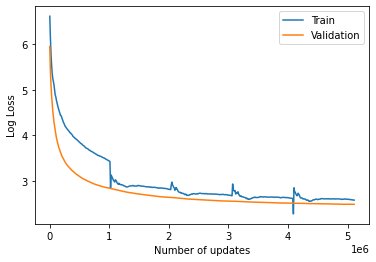

In [8]:
k = 10

w, V, training_losses, validation_losses = train(k=k)
print_losses(training_losses, validation_losses)

In [9]:
@jit(nopython=True)
def opti_hyper(X_train, X_train_square, y_train, list_k, y_valid=y_valid):
    predict_list = np.zeros((len(list_k), len(y_valid)))
    for i, k in enumerate(list_k):
        w, V, _, _ = train(k=k, X_train=X_train, X_train_square=X_train_square, y_train=y_train)
        predict_list[i] = predict(w, V)
    return predict_list

In [49]:
%%time
all_pred_list = [] 
all_frac = (0.1, 0.5, 1, 4, 8)

list_k = np.linspace(1, 20, 6).astype(int)
n_exp = 5

try:
    all_pred_list = np.load('../data/res_hyper.npy')
except:
    for frac in all_frac:
        print(frac)
        pred_list = []
        for _ in range(n_exp):
            sub_idx = np.random.choice(range(int(1e4+1), len(X_test)), size=int(len(X_train)*frac), 
                                       replace=False)
            X_sub, X_sub_square, y_sub = X_test[sub_idx], X_test_square[sub_idx], y_test[sub_idx]
            pred_list.append(opti_hyper(X_train, X_train_square, y_train, list_k))
        all_pred_list.append(pred_list)

        # save for each frac
        np.save('../data/res_hyper.npy', np.array(all_pred_list))

    all_pred_list = np.array(all_pred_list)

CPU times: user 2.57 ms, sys: 11.4 ms, total: 14 ms
Wall time: 11.3 ms


In [51]:
score = m.f1_score

all_score = []

for i, k in enumerate(list_k):
    for j, frac in enumerate(all_frac):
        for y_pred in all_pred_list[j, :, i]:
            all_score.append((score(y_valid, y_pred), k, frac))

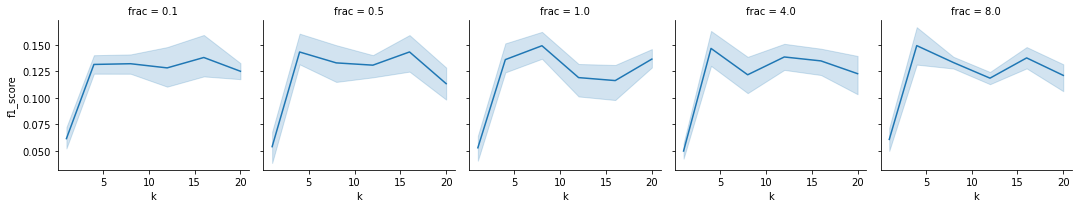

In [52]:
df_res = pd.DataFrame(all_score, columns=['f1_score', 'k', 'frac'])

g = sns.FacetGrid(df_res, col="frac")
g.map(sns.lineplot, "k", 'f1_score')
plt.show()

In [53]:
df_res = df_res.groupby(['frac', 'k']).mean()
df_res = df_res.reset_index().sort_values('f1_score', ascending=False)
df_res = df_res.groupby('frac').first()['k']

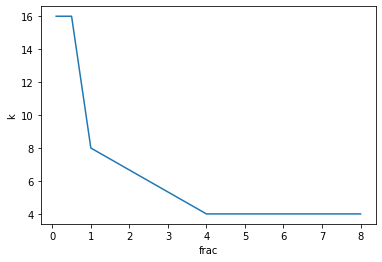

In [54]:
sns.lineplot(data=df_res)
plt.show()